## 本文将介绍吴恩达的机器学习课程中关于神经网络的编程作业3和4。这也是我们在课程中遇到的第一个复杂的非线性算法。我不了解你，但这个任务对于我来说肯定有一个陡峭的学习曲线。神经网络构成了深度学习的基础，它具有广泛的应用，如计算机视觉或自然语言处理。因此，重要的是获得基本权利并在python中编码这些赋值是确保这一点的一种方法。
## 在进入神经网络之前，让我们完成逻辑回归的最后一节 - 多类Logistic回归。
## 该系列练习利用由5000个训练示例组成的手写数字数据集，其中每个示例都是20×20像素的数字灰度图像。
# 加载数据集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
# Use loadmat to load matlab files
mat=loadmat("/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I122_learning_models/python实现吴恩达深度学习（英文版）/the_file_come_from_git_hub/NeuralNetworks/ex3data1.mat")
X=mat["X"]
y=mat["y"]

## 由于数据集是以.mat格式而不是通常的.txt格式给出的，因此我需要使用scipy loadmat函数。官方文档可以在这里找到。（https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.io.loadmat.html）由于loadmat将.mat文件作为带有变量名称作为键的字典加载，因此分配X和y就像使用变量的键访问dict一样简单

In [2]:
X.shape,y.shape

((5000, 400), (5000, 1))

## 为了更好地理解数据集，具有数据的形状可以告诉我们数据的维度。 X形状为5000,400，其对应5000个训练示例，每个示例具有来自其20×20像素的400个特征。 y具有5000,1的形状，其中每个训练示例具有范围从1到10的标签（在该数据集中'0'数字被标记为'10'）。

# 可视化数据

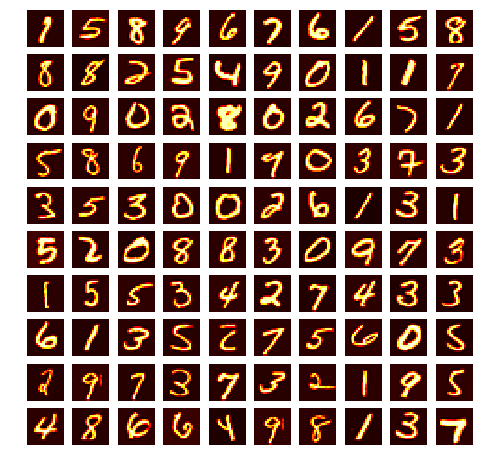

In [3]:
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")
plt.show()
plt.close()

## 上面的代码块构造了100个子图，并使用plt.imshow随机可视化5000个训练示例中的100个。请注意，我们必须将训练示例重新塑造为20 X 20像素，才能将其可视化并将order =“F”作为参数添加到重塑功能中，以确保图像的方向是垂直的。
# 计算成本函数和梯度

In [4]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    return 1/ (1 + np.exp(-z))
def lrCostFunction(theta, X, y, Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    
    m=len(y)
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0= 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

## 这类似于我们在Logistic回归分配中使用的成本函数

In [5]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t =np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
J, grad = lrCostFunction(theta_t, X_t, y_t, 3)
print("Cost（成本）:",J,"Expected cost（预期成本）: 2.534819")
print("Gradients（梯度）:\n",grad,"\nExpected gradients（预期的梯度）:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost（成本）: 2.53481939611 Expected cost（预期成本）: 2.534819
Gradients（梯度）:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients（预期的梯度）:
 0.146561
 -0.548558
 0.724722
 1.398003


## 现在进行分类任务。由于我们有多个类，我们必须使用一对一分类方法（每个类一个分类器）训练多个逻辑回归分类器。

In [6]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration

    使用numpy数组X, y和，并通过使用num_iter梯度步骤来更新的学习率

    在每次迭代中返回theta和theta的成本列表
    """
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = lrCostFunction(theta,X,y,Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta , J_history
def oneVsAll(X, y, num_labels, Lambda):
    """
    Takes in numpy array of X,y, int num_labels and float lambda to train multiple logistic regression classifiers
    depending on the number of num_labels using gradient descent. 
    
    Returns a matrix of theta, where the i-th row corresponds to the classifier for label i

    接受numpy数组的X,y, int num_label和浮点lambda来训练多个逻辑回归分类器
    
    取决于使用梯度下降的num_label的数量。

    返回一个矩阵，其中第i行对应于标签i的分类器
    """
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J=[]
    # add intercept terms
    
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1,num_labels+1):
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,1,300,Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels,n+1), all_J

In [21]:
all_theta, all_J = oneVsAll(X, y, 10, 0.1)

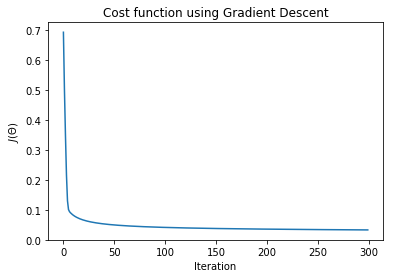

In [55]:
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.legend()
plt.show()

## 为了进行预测，计算每个类的x（i）的概率，并且预测为具有最高概率的类

In [23]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of X(i) for each class and predict the label
    
    return a vector of prediction
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)+1

In [25]:
pred = predictOneVsAll(all_theta, X)
print("Training Set Accuracy(训练集准确度):",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy(训练集准确度): 91.46 %


## 最后，神经网络的时间。使用相同的数据集，我们的目标是使用更复杂的算法（如神经网络）实现更高的精度。对于练习的第一部分，我们给出了优化的θ值，我们需要进行前馈传播以获得预测和模型精度。

## 加载优化的theta

In [28]:
mat2=loadmat("/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I122_learning_models/python实现吴恩达深度学习（英文版）/the_file_come_from_git_hub/NeuralNetworks/ex3weights.mat")
Theta1=mat2["Theta1"] # Theta1 has size 25 x 401
Theta2=mat2["Theta2"] # Theta2 has size 10 x 26

## 使用前馈传播进行预测

In [29]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    return np.argmax(a2,axis=1)+1

In [31]:
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy(训练集的准确性):",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy(训练集的准确性): 97.52 %


## 训练集准确度：97.52％。与多级逻辑回归相比，准确度更高！
# 在作业4中，我们致力于从头开始实现神经网络。我们首先计算成本函数和θ的梯度。

### 计算神经网络代价函数

$J(\Theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\Theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\Theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2]$

In [32]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    计算sigmoid函数的梯度
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid)
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    nn_params包含展开为向量的参数
    
    compute the cost and gradient of the neural network
    计算神经网络的代价和梯度
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

## 该作业分步骤进行，首先是正则化成本、梯度，最后是正则化梯度。如果你想继续，我修改了代码，只要你使用正确的索引，它就会返回中间步骤的值。

In [34]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
J,reg_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0:4:3]
print("Cost at parameters (non-regularized)/参数成本(非正则化):",J,"\nCost at parameters (Regularized):/参数成本(正规化)",reg_J)

Cost at parameters (non-regularized)/参数成本(非正则化): 0.287629165161 
Cost at parameters (Regularized):/参数成本(正规化) 0.383769859091


## flatten（）函数将数组折叠为一维，np.append将参数“展开”为向量。
## 在讲座中讨论了初始theta的对称性问题。为了打破这种对称性，需要随机初始化。

In [35]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    使用L_in传入连接和L_out传出连接随机初始化层的权值。
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [36]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [38]:
debug_J  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 3)
print("Cost at (fixed) debugging parameters (w/ lambda = 3)/调试参数(w/ lambda = 3):",debug_J[3])

Cost at (fixed) debugging parameters (w/ lambda = 3)/调试参数(w/ lambda = 3): 0.57605124695


## 最后，轮到我们使用前馈传播和反向传播来优化θ值。我正在使用的优化算法再次是相同的旧梯度下降。

# 使用梯度下行学习参数

In [40]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    使用numpy数组X, y和，并通过使用num_iter梯度步骤来更新的学习率
    
    return theta and the list of the cost of theta during each iteration
    在每次迭代中返回theta和theta的成本列表
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

## 下面我使用0.8表示alpha，对num_iters使用800

In [50]:
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,0.75,2600,1,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

## 对执行代码的人发出警告。根据您的计算能力计算需要相当长的时间，如果您正在优化alpha和num_iters值，则需要更长的时间。我使用0.8表示alpha，对num_iters使用800，但我相信使用更多的tunnin可以获得更好的准确性。

## 对执行代码的人发出警告。根据您的计算能力计算需要相当长的时间，如果您正在优化alpha和num_iters值，则需要更长的时间。我使用0.8表示alpha，对num_iters使用800，但我相信使用更多的tunnin可以获得更好的准确性。

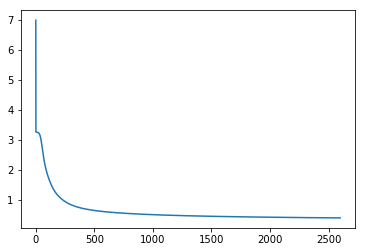

In [52]:
plt.plot(nnJ_history)
plt.show()

In [53]:
Theta1

array([[ -8.60987429e-01,   1.41505247e-03,  -1.55720260e-03, ...,
          9.52692351e-04,  -1.97758379e-03,  -1.90116841e-03],
       [ -9.98762826e-01,   7.32133793e-04,  -1.29034190e-03, ...,
         -1.69631008e-03,  -2.11969855e-03,   1.24306325e-03],
       [ -5.51188125e-01,   8.02079835e-04,   2.12980730e-03, ...,
         -1.47801212e-03,   3.76620141e-04,   7.85787510e-04],
       ..., 
       [ -6.64600822e-01,  -1.33568660e-03,  -1.78429305e-03, ...,
          3.90472076e-03,   4.05563721e-04,   1.80956212e-03],
       [  2.01695446e-01,  -2.22730687e-04,   3.29515331e-04, ...,
         -8.72000912e-04,  -7.95697514e-04,   1.15057585e-03],
       [ -6.94101005e-01,   1.29607654e-03,   1.55425665e-03, ...,
          3.92145680e-04,  -1.61606357e-03,  -2.04478308e-03]])

In [54]:
Theta2

array([[-0.9939572 ,  0.7111228 , -1.01516156, -2.23380384, -0.91531625,
        -1.01458275,  1.05170831,  2.44931443, -0.56494561, -1.13639333,
        -1.8276492 , -3.8174099 ,  0.24994534, -0.51796886,  0.52654655,
        -1.69575924,  0.97160213,  1.51927579, -1.85816897,  0.22369681,
         1.28605723,  0.52201663, -1.2471805 ,  0.89621742, -0.5371899 ,
         0.59982949],
       [-0.98687082,  1.99794703, -0.05061489, -2.30055644, -2.67476885,
        -1.07171731, -0.84740511, -1.72936223,  1.36994158, -0.12926524,
         1.5662627 ,  1.18755799, -2.3694357 , -1.70190358,  0.2210979 ,
         1.15903548, -2.44141196, -3.71626096, -1.7893101 , -0.12514125,
        -0.36370237,  0.5624064 , -1.69004058,  2.7779961 , -0.68516923,
         1.0235962 ],
       [-1.16989882, -1.55223791, -2.57578551,  1.42502733,  0.0600333 ,
         0.96456447, -2.56769809, -2.64763448, -1.47127021, -1.41877715,
        -1.30671566,  0.71754012, -0.81119865, -1.64785905, -1.05249925,
       

In [51]:
pred3 = predict(Theta1, Theta2, X)
print("Training Set Accuracy（训练集的准确性）:",sum(pred3[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy（训练集的准确性）: 97.08 %


GitHub传送门： (https://github.com/benlau93 / machine - learning by andrew - ng- in- python)

后续期待

来源：https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-neural-networks-e526b41fdcd9